+  导入模块

In [1]:
import gc
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

+ 2. 加载小样本进行测试

In [2]:
# 加载小样本
user_log = pd.read_csv('./data_format1_small/sample_user_log.csv', dtype={'time_stamp': 'str'})
user_info = pd.read_csv('./data_format1_small/sample_user_info.csv')
train_data1 = pd.read_csv('./data_format1_small/train.csv')
submission = pd.read_csv('./data_format1_small/test.csv')
train_data = pd.read_csv('./data_format2/train_format2.csv')

In [3]:
train_data1['origin'] = 'train'
submission['origin'] = 'test'
matrix = pd.concat([train_data1, submission], ignore_index=True, sort=False)
# print(matrix)

In [4]:

# 使用merchant_id（原列名seller_id）
user_log.rename(columns={'seller_id': 'merchant_id'}, inplace=True)
# 格式化
user_log['user_id'] = user_log['user_id'].astype('int32')
user_log['merchant_id'] = user_log['merchant_id'].astype('int32')
user_log['item_id'] = user_log['item_id'].astype('int32')
user_log['cat_id'] = user_log['cat_id'].astype('int32')
user_log['brand_id'].fillna(0, inplace=True)
user_log['brand_id'] = user_log['brand_id'].astype('int32')
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%H%M')

# 对离散特征做LabelEncoder
lbe_merchant_id = LabelEncoder()
lbe_merchant_id.fit(np.r_[0, user_log['merchant_id'].values])
user_log['merchant_id'] = lbe_merchant_id.transform(user_log['merchant_id'])
matrix['merchant_id'] = lbe_merchant_id.transform(matrix['merchant_id'])

lbe_user_id = LabelEncoder()
user_log['user_id'] = lbe_user_id.fit_transform(user_log['user_id'])
user_info['user_id'] = lbe_user_id.transform(user_info['user_id'])
matrix['user_id'] = lbe_user_id.transform(matrix['user_id'])

lbe_item_id = LabelEncoder()
user_log['item_id'] = lbe_item_id.fit_transform(user_log['item_id'])
lbe_cat_id = LabelEncoder()
user_log['cat_id'] = lbe_cat_id.fit_transform(user_log['cat_id'])
lbe_brand_id = LabelEncoder()
user_log['brand_id'] = lbe_brand_id.fit_transform(user_log['brand_id'])

user_log['merchant_id'].max(), user_log['user_id'].max()
matrix = matrix.merge(user_info, on='user_id', how='left')

# 1 for <18; 2 for [18,24]; 3 for [25,29]; 4 for [30,34]; 5 for [35,39]; 6 for [40,49]; 7 and 8 for >= 50; 0 and NULL for unknown
matrix['age_range'].fillna(0, inplace=True)
# 0:female, 1:male, 2:unknown
matrix['gender'].fillna(2, inplace=True)
matrix['age_range'] = matrix['age_range'].astype('int8')
matrix['gender'] = matrix['gender'].astype('int8')
matrix['label'] = matrix['label'].astype('str')
matrix['user_id'] = matrix['user_id'].astype('int32')
matrix['merchant_id'] = matrix['merchant_id'].astype('int32')
del user_info, train_data1
gc.collect()
print(matrix)

# User特征处理
groups = user_log.groupby(['user_id'])
# 用户交互行为数量 u1
temp = groups.size().reset_index().rename(columns={0: 'u1'})
matrix = matrix.merge(temp, on='user_id', how='left')
# 使用agg 基于列的聚合操作，统计唯一值的个数 item_id, cat_id, merchant_id, brand_id
# temp = groups['item_id', 'cat_id', 'merchant_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'u2', 'cat_id':'u3', 'merchant_id':'u4', 'brand_id':'u5'})
temp = groups['item_id'].agg([('u2', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['cat_id'].agg([('u3', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['merchant_id'].agg([('u4', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['brand_id'].agg([('u5', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')

# 时间间隔特征 u6 按照小时
temp = groups['time_stamp'].agg([('F_time', 'min'), ('L_time', 'max')]).reset_index()
temp['u6'] = (temp['L_time'] - temp['F_time']).dt.seconds / 3600
matrix = matrix.merge(temp[['user_id', 'u6']], on='user_id', how='left')
# 统计action_type为0，1，2，3的个数（原始操作，没有补0）
temp = groups['action_type'].value_counts().unstack().reset_index().rename(
    columns={0: 'u7', 1: 'u8', 2: 'u9', 3: 'u10'})
matrix = matrix.merge(temp, on='user_id', how='left')
# print(matrix)

# 商家特征处理
groups = user_log.groupby(['merchant_id'])
# 商家被交互行为数量 m1
temp = groups.size().reset_index().rename(columns={0: 'm1'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的user_id, item_id, cat_id, brand_id 唯一值
temp = groups[['user_id', 'item_id', 'cat_id', 'brand_id']].nunique().reset_index().rename(
    columns={'user_id': 'm2', 'item_id': 'm3', 'cat_id': 'm4', 'brand_id': 'm5'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的action_type 唯一值
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0: 'm6', 1: 'm7', 2: 'm8', 3: 'm9'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 按照merchant_id 统计随机负采样的个数
temp = train_data[train_data['label'] == -1].groupby(['merchant_id']).size().reset_index().rename(columns={0: 'm10'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# print(matrix)

# 按照user_id, merchant_id分组
groups = user_log.groupby(['user_id', 'merchant_id'])
temp = groups.size().reset_index().rename(columns={0: 'um1'})  # 统计行为个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups[['item_id', 'cat_id', 'brand_id']].nunique().reset_index().rename(
    columns={'item_id': 'um2', 'cat_id': 'um3', 'brand_id': 'um4'})  # 统计item_id, cat_id, brand_id唯一个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['action_type'].value_counts().unstack().reset_index().rename(
    columns={0: 'um5', 1: 'um6', 2: 'um7', 3: 'um8'})  # 统计不同action_type唯一个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['time_stamp'].agg([('first', 'min'), ('last', 'max')]).reset_index()
temp['um9'] = (temp['last'] - temp['first']).dt.seconds / 3600
temp.drop(['first', 'last'], axis=1, inplace=True)
print(temp)
print('-' * 100)
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')  # 统计时间间隔
# print(matrix)

# 用户购买点击比
matrix['r1'] = matrix['u9'] / matrix['u7']
# 商家购买点击比
matrix['r2'] = matrix['m8'] / matrix['m6']
# 不同用户不同商家购买点击比
matrix['r3'] = matrix['um7'] / matrix['um5']
matrix.fillna(0, inplace=True)
# # 修改age_range字段名称为 age_0, age_1, age_2... age_8
temp = pd.get_dummies(matrix['age_range'], prefix='age')
matrix = pd.concat([matrix, temp], axis=1)
temp = pd.get_dummies(matrix['gender'], prefix='g')
matrix = pd.concat([matrix, temp], axis=1)
matrix.drop(['age_range', 'gender'], axis=1, inplace=True)
# print(matrix)

       user_id  merchant_id label origin  prob  age_range  gender
0        16497         1203   0.0  train   NaN          0       1
1         1950          946   0.0  train   NaN          2       0
2        10829         2278   0.0  train   NaN          3       0
3         7974          951   0.0  train   NaN          0       1
4        14604         1892   0.0  train   NaN          7       0
...        ...          ...   ...    ...   ...        ...     ...
23888     2157         1748   nan   test   0.0          0       0
23889     2673          798   nan   test   0.0          3       0
23890    11847          639   nan   test   0.0          2       1
23891    11847         3953   nan   test   0.0          2       1
23892    19079         2954   nan   test   0.0          4       0

[23893 rows x 7 columns]
        user_id  merchant_id       um9
0             0          186  0.883333
1             0          202  0.000000
2             0          523  0.000000
3             0          7

In [5]:
#   留出padding的空位  
lbe_action_type = {0: 1, 1: 2, 2: 3, 3: 4}
user_log['action_type'] = user_log['action_type'].map(lbe_action_type)
# 用户行为sequence
# 把user_log里同user的这些数据合并成一个list
# 构建用户点击行为的序列， pading成 相同的长度进行学习
#  用户点击的序列 长度不是一致的

temp = pd.DataFrame(user_log.groupby('user_id')[['merchant_id', 'action_type']].agg(lambda x: list(x)))
# 列名称改成hist_merchant_id 和 hist_action_type
temp.columns = ['hist_merchant_id', 'hist_action_type']
# print(temp)
matrix = matrix.merge(temp, on=['user_id'], how='left')  # 统计时间间隔
print(matrix)

# 截取，不缺到定长M个
# 训练集中所有用户为进行点击的item 
# 类似与NLP中 VOCAB 中的UNKNOW 
# pading 

M = 500
for feature in ['hist_merchant_id', 'hist_action_type']:
    matrix[feature] = matrix[feature].map(lambda x: np.array(x + [0] * (M - len(x)))[:M])

       user_id  merchant_id label origin  prob    u1   u2  u3  u4  u5  ...  \
0        16497         1203   0.0  train   0.0    46   29  12  16  16  ...   
1         1950          946   0.0  train   0.0   365  198  46  46  45  ...   
2        10829         2278   0.0  train   0.0    47   31  14  15  17  ...   
3         7974          951   0.0  train   0.0   234  105  23  35  36  ...   
4        14604         1892   0.0  train   0.0   186  106  34  40  39  ...   
...        ...          ...   ...    ...   ...   ...  ...  ..  ..  ..  ...   
23888     2157         1748   nan   test   0.0   128   97  28  39  40  ...   
23889     2673          798   nan   test   0.0  1286  540  55  93  96  ...   
23890    11847          639   nan   test   0.0     9    8   7   7   7  ...   
23891    11847         3953   nan   test   0.0     9    8   7   7   7  ...   
23892    19079         2954   nan   test   0.0   197   85  36  39  40  ...   

       age_4  age_5  age_6  age_7  age_8  g_0  g_1  g_2  \
0   

In [6]:
matrix.dtypes

user_id               int32
merchant_id           int32
label                object
origin               object
prob                float64
u1                    int64
u2                    int64
u3                    int64
u4                    int64
u5                    int64
u6                  float64
u7                  float64
u8                  float64
u9                  float64
u10                 float64
m1                    int64
m2                    int64
m3                    int64
m4                    int64
m5                    int64
m6                  float64
m7                  float64
m8                  float64
m9                  float64
m10                   int64
um1                   int64
um2                   int64
um3                   int64
um4                   int64
um5                 float64
um6                 float64
um7                 float64
um8                 float64
um9                 float64
r1                  float64
r2                  

In [7]:
# 分割训练数据和测试数据
train_data = matrix[matrix['origin'] == 'train'].drop(['origin'], axis=1)
test_data = matrix[matrix['origin'] == 'test'].drop(['label', 'origin'], axis=1)
train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']
print(train_X)

       user_id  merchant_id  prob   u1   u2  u3  u4  u5        u6     u7  ...  \
0        16497         1203   0.0   46   29  12  16  16  4.933333   45.0  ...   
1         1950          946   0.0  365  198  46  46  45  5.866667  313.0  ...   
2        10829         2278   0.0   47   31  14  15  17  5.833333   42.0  ...   
3         7974          951   0.0  234  105  23  35  36  5.833333  177.0  ...   
4        14604         1892   0.0  186  106  34  40  39  5.866667  147.0  ...   
...        ...          ...   ...  ...  ...  ..  ..  ..       ...    ...  ...   
17832    18547         3825   0.0   40   24  13  14  15  4.916667   27.0  ...   
17833    18693         3443   0.0   15   12  10  10  10  6.000000   10.0  ...   
17834     4034         4172   0.0   16   14   8  11  12  5.833333   15.0  ...   
17835    16017          993   0.0   33   25  12  15  15  4.916667   31.0  ...   
17836     7308         4723   0.0   94   50  18  24  22  5.766667   80.0  ...   

       age_4  age_5  age_6 

In [8]:
train_X.dtypes

user_id               int32
merchant_id           int32
prob                float64
u1                    int64
u2                    int64
u3                    int64
u4                    int64
u5                    int64
u6                  float64
u7                  float64
u8                  float64
u9                  float64
u10                 float64
m1                    int64
m2                    int64
m3                    int64
m4                    int64
m5                    int64
m6                  float64
m7                  float64
m8                  float64
m9                  float64
m10                   int64
um1                   int64
um2                   int64
um3                   int64
um4                   int64
um5                 float64
um6                 float64
um7                 float64
um8                 float64
um9                 float64
r1                  float64
r2                  float64
r3                  float64
age_0               

In [9]:
train_X.hist_merchant_id.map(len)

0        500
1        500
2        500
3        500
4        500
        ... 
17832    500
17833    500
17834    500
17835    500
17836    500
Name: hist_merchant_id, Length: 17837, dtype: int64

In [10]:
train_X.hist_merchant_id[0]

array([3735, 1203, 3490, 2968, 3510, 3510, 3388,  610, 1327, 1327, 3454,
       3454, 1203,  422, 1203,  207, 1203, 1203, 1875,  422, 1875, 1875,
        422, 3454, 1860, 3705,  422, 3454, 1203,  422, 3454, 3454, 1203,
       1825, 1875, 3454, 3454, 3705, 3454, 2062, 1875,  207, 3454, 1203,
       3454, 1327,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [11]:
train_X.hist_action_type[0]

array([1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
# 使用DIN模型
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss
from deepctr.inputs import SparseFeat, VarLenSparseFeat, DenseFeat, get_feature_names
from deepctr.models import DIN, DIEN, DSIN
from sklearn.metrics import classification_report

train_X['action_type'] = 3
feature_columns = []
for column in train_X.columns:
    if column != 'hist_merchant_id' and column != 'hist_action_type':
        print(column)
        num = train_X[column].nunique()
        if num > 10000:
            dim = 10
        else:
            if num > 1000:
                dim = 8
            else:
                dim = 4
        print(num)
        if column == 'user_id':
            feature_columns += [SparseFeat(column, 19111 + 1, embedding_dim=dim)]
        elif column == 'merchant_id':
            feature_columns += [SparseFeat(column, 4994 + 1, embedding_dim=dim)]
        elif column == 'action_type':
            feature_columns += [SparseFeat(column, 4 + 1, embedding_dim=dim)]
        else:
            feature_columns += [DenseFeat(column, 1)]

user_id
14488
merchant_id
1856
prob
1
u1
825
u2
539
u3
124
u4
246
u5
237
u6
184
u7
772
u8
17
u9
79
u10
161
m1
805
m2
406
m3
292
m4
56
m5
35
m6
757
m7
23
m8
208
m9
163
m10
1294
um1
170
um2
94
um3
22
um4
12
um5
166
um6
8
um7
10
um8
26
um9
184
r1
3265
r2
1413
r3
394
age_0
2
age_2
2
age_3
2
age_4
2
age_5
2
age_6
2
age_7
2
age_8
2
g_0
2
g_1
2
g_2
2
action_type
1


In [13]:

# maxlen为历史信息的长度，vocabulary_size为onehot的长度
feature_columns += [VarLenSparseFeat(
    SparseFeat('hist_merchant_id',
               vocabulary_size=19111 + 1,
               embedding_dim=8,
               embedding_name='merchant_id'), maxlen=M),
    VarLenSparseFeat(SparseFeat('hist_action_type',
                    vocabulary_size=4 + 1,
                    embedding_dim=4,
                    embedding_name='action_type'), maxlen=M)]

hist_features = ['merchant_id', 'action_type']
print(feature_columns)

[SparseFeat(name='user_id', vocabulary_size=19112, embedding_dim=10, use_hash=False, dtype='int32', embedding_name='user_id', group_name='default_group'), SparseFeat(name='merchant_id', vocabulary_size=4995, embedding_dim=8, use_hash=False, dtype='int32', embedding_name='merchant_id', group_name='default_group'), DenseFeat(name='prob', dimension=1, dtype='float32'), DenseFeat(name='u1', dimension=1, dtype='float32'), DenseFeat(name='u2', dimension=1, dtype='float32'), DenseFeat(name='u3', dimension=1, dtype='float32'), DenseFeat(name='u4', dimension=1, dtype='float32'), DenseFeat(name='u5', dimension=1, dtype='float32'), DenseFeat(name='u6', dimension=1, dtype='float32'), DenseFeat(name='u7', dimension=1, dtype='float32'), DenseFeat(name='u8', dimension=1, dtype='float32'), DenseFeat(name='u9', dimension=1, dtype='float32'), DenseFeat(name='u10', dimension=1, dtype='float32'), DenseFeat(name='m1', dimension=1, dtype='float32'), DenseFeat(name='m2', dimension=1, dtype='float32'), DenseF

In [14]:
import pprint
pprint.pprint( feature_columns)

[SparseFeat(name='user_id', vocabulary_size=19112, embedding_dim=10, use_hash=False, dtype='int32', embedding_name='user_id', group_name='default_group'),
 SparseFeat(name='merchant_id', vocabulary_size=4995, embedding_dim=8, use_hash=False, dtype='int32', embedding_name='merchant_id', group_name='default_group'),
 DenseFeat(name='prob', dimension=1, dtype='float32'),
 DenseFeat(name='u1', dimension=1, dtype='float32'),
 DenseFeat(name='u2', dimension=1, dtype='float32'),
 DenseFeat(name='u3', dimension=1, dtype='float32'),
 DenseFeat(name='u4', dimension=1, dtype='float32'),
 DenseFeat(name='u5', dimension=1, dtype='float32'),
 DenseFeat(name='u6', dimension=1, dtype='float32'),
 DenseFeat(name='u7', dimension=1, dtype='float32'),
 DenseFeat(name='u8', dimension=1, dtype='float32'),
 DenseFeat(name='u9', dimension=1, dtype='float32'),
 DenseFeat(name='u10', dimension=1, dtype='float32'),
 DenseFeat(name='m1', dimension=1, dtype='float32'),
 DenseFeat(name='m2', dimension=1, dtype='flo

In [15]:
# # 使用DIN模型
# model = DIN(feature_columns, hist_features)
# # 使用Adam优化器，二分类的交叉熵
# model.compile('adam', 'binary_crossentropy', metrics=['binary_crossentropy'])

# # 组装train_model_input，得到feature names，将train_X转换为字典格式
# feature_names = list(train_X.columns)
# train_model_input = {name: train_X[name].values for name in feature_names}

In [16]:
# from tqdm import tqdm

# for fea in ['hist_merchant_id', 'hist_action_type']:
#     l = []
#     for i in tqdm(train_model_input[fea]):
#         l.append(i)
#     train_model_input[fea] = np.array(l)

In [17]:
# history = model.fit(train_model_input, 
#                     train_y.astype(np.float), 
#                     verbose=True, 
#                     epochs=10, 
#                     validation_split=0.2,
#                     batch_size=512)

+ 必须设置early_stoping 

In [18]:
from tensorflow.keras.metrics import  AUC 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam

# 使用DIN模型
model = DIN(feature_columns, hist_features)
# 使用Adam优化器，二分类的交叉熵
model.compile(Adam(1e-3), 
              'binary_crossentropy',
              metrics=['binary_crossentropy' ,])

# 组装train_model_input，得到feature names，将train_X转换为字典格式
feature_names = list(train_X.columns)
train_model_input = {name: train_X[name].values for name in feature_names}
from tqdm import tqdm

for fea in ['hist_merchant_id', 'hist_action_type']:
    l = []
    for i in tqdm(train_model_input[fea]):
        l.append(i)
    train_model_input[fea] = np.array(l)
    
es = EarlyStopping(
     monitor='val_binary_crossentropy', 
     min_delta=0.01, patience=3, verbose=0,
        restore_best_weights=True)

history = model.fit(train_model_input, 
                    train_y.astype(np.float), 
                    verbose=True, 
                    epochs=10, 
                    validation_split=0.2,
                    batch_size=512,
                    callbacks =[es])

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'attention_sequence_pooling_layer/local_activation_unit/kernel:0' shape=(40, 1) dtype=float32>
  <tf.Variable 'attention_sequence_pooling_layer/local_activation_unit/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


100%|██████████████████████████████████████████████████████████████████████████████| 17837/17837 [00:00<00:00, 911363.14it/s]


Train on 14269 samples, validate on 3568 samples
Epoch 1/10


C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


14269/14269 [==============================] - 69s 5ms/sample - loss: 1.2211 - binary_crossentropy: 1.2211 - val_loss: 0.9338 - val_binary_crossentropy: 0.9338
Epoch 2/10
14269/14269 [==============================] - 64s 5ms/sample - loss: 0.9135 - binary_crossentropy: 0.9135 - val_loss: 0.9338 - val_binary_crossentropy: 0.9338
Epoch 3/10
14269/14269 [==============================] - 63s 4ms/sample - loss: 0.9135 - binary_crossentropy: 0.9135 - val_loss: 0.9338 - val_binary_crossentropy: 0.9338
Epoch 4/10
14269/14269 [==============================] - 66s 5ms/sample - loss: 0.9135 - binary_crossentropy: 0.9135 - val_loss: 0.9338 - val_binary_crossentropy: 0.9338


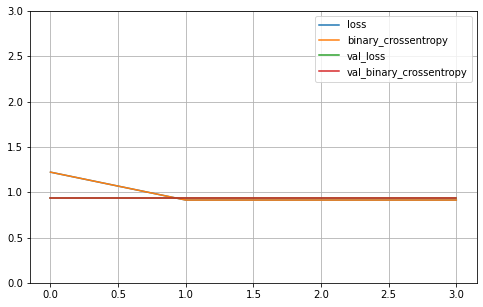

In [19]:
import matplotlib.pyplot as plt 
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3 )
    plt.show()

plot_learning_curves(history)